In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

%cd ..
project_root = Path.cwd()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from musicagent.config import DataConfig
from musicagent.data import OfflineDataset, make_offline_collate_fn
from musicagent.eval.metrics import (
    chord_length_entropy,
    chord_lengths,
    chord_silence_counts,
    note_in_chord_ratio,
    onset_interval_emd,
    onset_intervals,
)
from musicagent.utils import compute_test_set_histograms

d_cfg = DataConfig()
if not d_cfg.data_processed.is_absolute():
    d_cfg.data_processed = project_root / d_cfg.data_processed

test_ds = OfflineDataset(d_cfg, split="test")
collate_fn = make_offline_collate_fn(pad_id=d_cfg.pad_id)

test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

mel_id_to_token = test_ds.melody_id_to_token
chord_id_to_token = test_ds.chord_id_to_token


def decode_melody(ids):
    return [mel_id_to_token.get(int(i), "<unk>") for i in ids]


def decode_chords(ids):
    return [chord_id_to_token.get(int(i), "<unk>") for i in ids]

/Users/drewtaylor/data


/Users/drewtaylor/data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reference test-set metrics (ground-truth melody/chord pairs)

all_nic_ref: list[float] = []
all_ref_intervals: list[int] = []
all_ref_lengths: list[int] = []

# Additional aggregates to mirror offline/online eval metrics
total_silent_frames = 0
total_melody_frames = 0
total_long_chords = 0
total_chords = 0
early_stop_sequences = 0
num_sequences = 0


def _ended_early(mel_ids: list[int], chord_ids: list[int]) -> bool:
    """Return True if the chord sequence ends (EOS) before the melody.

    This mirrors the logic used in offline/online evaluation so that we can
    verify the dataset itself does not exhibit early stopping.
    """

    try:
        eos_idx = chord_ids.index(d_cfg.eos_id)
    except ValueError:
        # No EOS in chords – treat as not early.
        return False

    # Find last non-PAD frame in melody.
    last_mel_idx = len(mel_ids) - 1
    while last_mel_idx >= 0 and mel_ids[last_mel_idx] == d_cfg.pad_id:
        last_mel_idx -= 1

    if last_mel_idx <= 0:
        return False
    return eos_idx < last_mel_idx


for src, tgt in test_loader:
    for i in range(src.size(0)):
        mel_ids = src[i].cpu().tolist()
        chord_ids = tgt[i].cpu().tolist()

        mel_tokens = decode_melody(mel_ids)
        chord_tokens = decode_chords(chord_ids)

        # NiC (reference upper bound using ground-truth chords)
        nic = note_in_chord_ratio(mel_tokens, chord_tokens)
        all_nic_ref.append(nic)

        # Onset intervals and chord lengths
        all_ref_intervals.extend(onset_intervals(mel_tokens, chord_tokens))
        lengths = chord_lengths(chord_tokens)
        all_ref_lengths.extend(lengths)

        # Silence / long-chord statistics (predicted-only metrics in eval,
        # but here computed for the reference chords).
        silent, total = chord_silence_counts(mel_tokens, chord_tokens)
        total_silent_frames += silent
        total_melody_frames += total

        long_threshold = 32
        total_long_chords += sum(1 for L in lengths if L > long_threshold)
        total_chords += len(lengths)

        # Early-stop check on reference data (should be ~0%).
        if _ended_early(mel_ids, chord_ids):
            early_stop_sequences += 1

        num_sequences += 1


import numpy as np

avg_nic_ref = float(np.mean(all_nic_ref)) if all_nic_ref else 0.0
std_nic_ref = float(np.std(all_nic_ref)) if all_nic_ref else 0.0
ref_emd_self = onset_interval_emd(all_ref_intervals, all_ref_intervals)
ref_entropy = chord_length_entropy(all_ref_lengths)

silence_ratio = (
    (total_silent_frames / total_melody_frames) * 100.0 if total_melody_frames > 0 else 0.0
)
long_chord_ratio = (total_long_chords / total_chords) * 100.0 if total_chords > 0 else 0.0
early_stop_ratio = (early_stop_sequences / num_sequences) * 100.0 if num_sequences > 0 else 0.0

print(f"Reference NiC:                 {avg_nic_ref * 100:.2f}% (±{std_nic_ref * 100:.2f}%)")
print(f"Reference Onset Interval EMD:  {ref_emd_self * 1e3:.2f} ×10⁻³")
print(f"Reference Chord Length Entropy:{ref_entropy:.2f}")
print(f"Reference Chord Silence Ratio: {silence_ratio:.2f}%")
print(f"Reference Long Chord Ratio:    {long_chord_ratio:.2f}%")
print(f"Reference Early Stop Ratio:    {early_stop_ratio:.2f}%")

Reference NiC:                 65.31% (±26.42%)
Reference Onset Interval EMD:  0.00 ×10⁻³
Reference Chord Length Entropy:2.26
Reference Chord Silence Ratio: 3.22%
Reference Long Chord Ratio:    0.99%
Reference Early Stop Ratio:    0.00%


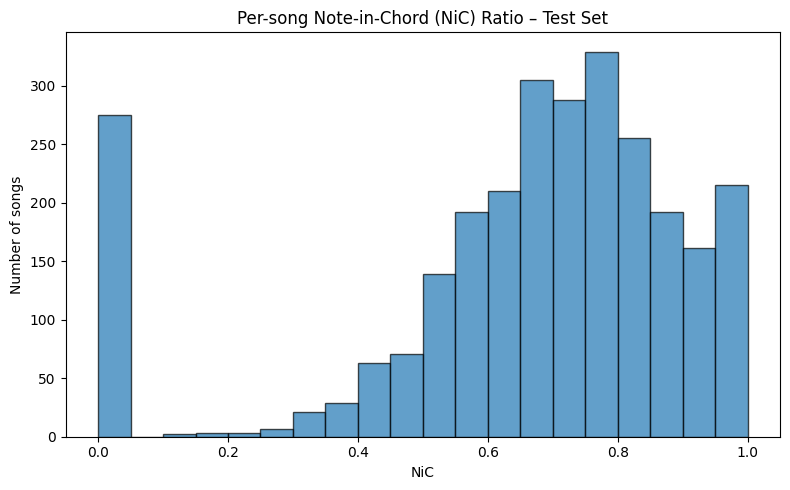

In [3]:
# Per-song Note-in-Chord (NiC) Ratio distribution for the test set (reference chords)

if not all_nic_ref:
    raise ValueError("all_nic_ref is empty – run the previous cell that computes test-set metrics first.")

plt.figure(figsize=(8, 5))
plt.hist(all_nic_ref, bins=20, range=(0.0, 1.0), alpha=0.7, edgecolor="black")
plt.title("Per-song Note-in-Chord (NiC) Ratio – Test Set")
plt.xlabel("NiC")
plt.ylabel("Number of songs")
plt.tight_layout()
plt.show()
